In [1]:
import matplotlib.pyplot as plt
from numpy import *

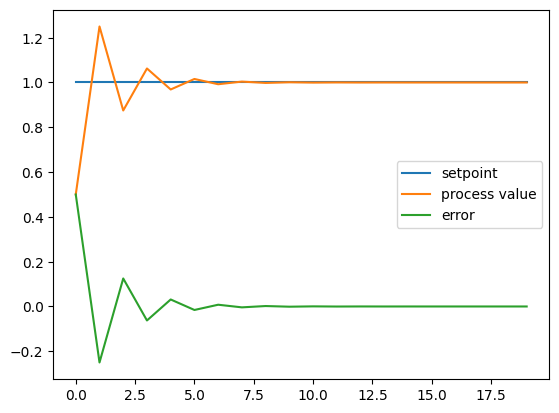

In [20]:
# simple P loop with static initial error
# this is similar to when we stabilize laser power before each experiment measurement,
# because if the laser drift is slow, the error won't be fighting against the feedback
kp = -0.5
err = 0.5
sp = 1
iters = 20

error = zeros(iters)
error[0] = err
output = zeros(iters)

for i in range(1,iters):
    error[i] = kp*error[i-1]

plt.plot(range(iters),iters*[sp],label='setpoint')
plt.plot(range(iters),sp-error,label='process value')
plt.plot(range(iters),error,label='error')
plt.legend()

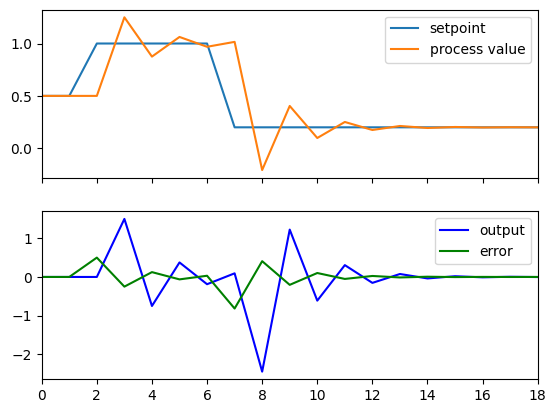

In [87]:
# P loop with setpoint changed a couple of times
kp = 3 # the gain is too high!
iters = 20

error = zeros(iters)
pv = zeros(iters)
pv[0] = 0.5
sp = [0.5]*2+[1]*5+[0.2]*(iters-7)
error[0] = sp[0] - pv[0] 
output = zeros(iters)
g = 0.5 # the gain or transfer function of the feedback

for i in range(1,iters):
    error[i-1] = sp[i-1] - pv[i-1]
    output[i] = kp*(error[i-1])
    pv[i] = g*output[i] + pv[i-1]

steps = range(iters)    
fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
ax,ax1 = axes
ax.plot(steps,sp,label='setpoint')
ax.plot(steps,pv,label='process value')
ax1.plot(steps,output,label='output',c='blue')
ax1.plot(steps,error,label='error',c='green')

for ax in axes:
    ax.set_xlim((0,iters-2))
    ax.legend()

plt.show()

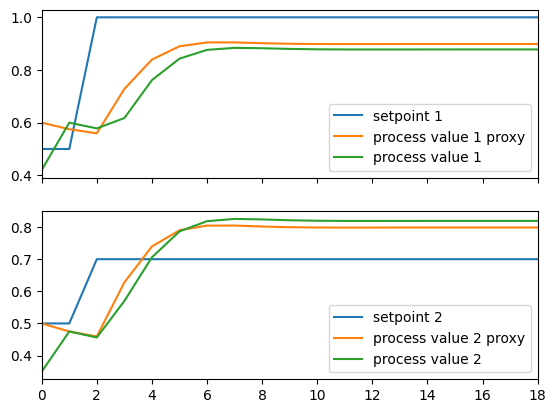

In [105]:
# coupled P loops. no varying noise. one change to the setpoint of each channel.
"""
suppose we have a coupled system
- two ouptuts, two PVs, two SPs. but the output effects the measurement of both systems, 
and we want to stabilize both PVs to their respective setpoints. that is, each
feedback actuator only affects one of the channels, but the measuremment is only a proxy
for the real signal because it is modulated by the other feedback channel. this situation 
describes the fiber AOM feedback scheme. 

below, output represents the deviation from the RF power driving the AOM at the
last iteration. the factors g1,2 convert to diffraction efficiency (assuming we can
linearize the AOM response in a small range)
"""

kp1 = kp2 = 0.5
iters = 20

error1 = zeros(iters)
error2 = zeros(iters)

pv1 = zeros(iters)
pv1[0] = 0.6

pv2 = zeros(iters)
pv2[0] = 0.5

pv1real = pv1*0.7 # suppose 0.7 is the AOM efficiency when "output" is 0
pv2real = pv2*0.7

sp1 = [0.5]*2+[1]*(iters-2)
sp2 = [0.5]*2+[0.7]*(iters-2)

output1 = zeros(iters)
output2 = zeros(iters)

error1[0] = sp1[0] - pv1[0]/(0.7+g*output2[0])
error2[0] = sp2[0] - pv2[0]/(0.7+g*output1[0])

g1 = g2 = 0.5 # the gain or transfer function of the feedback

for i in range(1,iters):
    error1[i-1] = sp1[i-1] - pv1[i-1]/(1+g2*output2[i-1])
    error2[i-1] = sp2[i-1] - pv2[i-1]/(1+g1*output1[i-1])
    
    output1[i] = kp1*(error1[i-1])
    output2[i] = kp2*(error2[i-1])
    
    # this is what is measured. really, the system is multiplicative not additive.
    pv1[i] = g1*output1[i] + g2*output2[i] + pv1[i-1]
    pv2[i] = g1*output1[i] + g2*output2[i] + pv2[i-1]
    
    # the actual signal we want to stabilize is "between" the two feedback actuators, 
    # but pv1,2 are measured after both feedback channels so they are proportional 
    # to the real signals
    pv1real[i] = pv1[i] - g1*output1[i]
    pv2real[i] = pv2[i] - g2*output2[i]

steps = range(iters)

fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
ax,ax1 = axes
ax.plot(steps,sp1,label='setpoint 1')
ax.plot(steps,pv1,label='process value 1 proxy')
ax.plot(steps,pv1real,label='process value 1')
ax1.plot(steps,sp2,label='setpoint 2')
ax1.plot(steps,pv2,label='process value 2 proxy')
ax1.plot(steps,pv2real,label='process value 2')

for ax in axes:
    ax.set_xlim((0,iters-2))
    ax.legend()

plt.show()

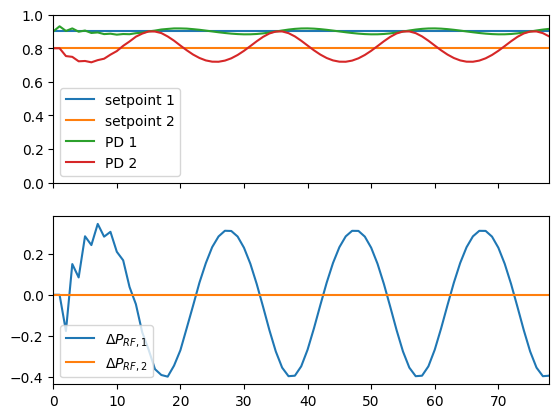

In [209]:
# coupled P loops - solve by using history and transfer functions
"""
suppose we have a coupled system
- two ouptuts, two PVs, two SPs. but the output effects the measurement of both systems, 
and we want to stabilize both PVs to their respective setpoints. that is, each
feedback actuator only affects one of the channels, but the measuremment is only a proxy
for the real signal because it is modulated by the other feedback channel. this situation 
describes the fiber AOM feedback scheme. 

if we change only one AOM in the pair at a time, then we can measure how much the 
diffraction efficiency changed. then we can "subtract" off that change when we measure the power
on the other arm. in this scheme, the setpoint refers to the adjusted values - i.e. we do not
try to hold the PD value to a particular voltage. we try to keep the scaled value constant.

the reason for this can be seen as follows: suppose a sinusoidally varying slow noise is on 
only channel 1, while channel 2 has no noise. the correct response is to sinusoidally vary
the AOM 1 power. however, now it looks like there is noise on the beam 2, so we have to divide
by the change caused by AOM 1 to the channel 2 signal in order to see that we should not vary
the power of AOM 2.

the setpoints used are obviously not absolute, since we don't actually know what the beam power
is in the region of interest, i.e. between the AOMs. hence, the setpoint corresponds to whatever
value is read on the PD when conditions are observed to be "good". however, only the corrected
process value can be expected to equal the setpoint, per the points made above.
"""

kp1 = kp2 = 3.6
iters = 80

error1 = zeros(iters)
error2 = zeros(iters)

sp1 = 0.9
sp2 = 0.8

pv1 = zeros(iters) # the value measured by the photodiode (PD)
pv1[0] = sp1

pv2 = zeros(iters)
pv2[0] = sp2 # this is the baseline power seen at the PD

output1 = zeros(iters) # the change in RF power compared to the last iteration
output2 = zeros(iters)

error1[0] = sp1 - pv1[0] # 0. only valid at the moment the setpoint is defined
error2[0] = sp2 - pv2[0]

g1 = g2 = 0.5 # the gain or transfer function of the feedback

noise1 = lambda i: 0.1*sin(2*pi*i/20) # slow fiber drift
noise2 = lambda i: 0.0

dpv2 = dpv1 = 0 # percent change in power due to AOM compared to last cycle. starts at zero by definition

eta1 = 1 # the diffraction efficiency of AOM 1. we can set it to 1 here for convenience.
eta2 = 1 # the diffraction efficiency of AOM 1. we can set it to 1 here for convenience.

for i in range(1,iters):
    
    # measure power on ch1. even if noise=0, a previous change to the other AOM will cause apparent fluctuation
    pv1[i] = (pv1[0] + noise1(i))*eta1*eta2

    # adjust AOM1 but factor out the change induced by AOM2
    error1[i] = sp1 - pv1[i-1]/(1+dpv2)
    output1[i] = kp1*error1[i]
    pv1_temp = pv1[i] # the power on this iteration before correcting
    pv1[i] += g1*output1[i]
    dpv1 = (pv1[i] - pv1_temp)/pv1_temp # percent change in power due to AOM
    eta1 *= (1+dpv1)
    
    # measure power on ch2
    pv2[i] = (pv2[0] + noise2(i))*eta1*eta2
    
    # adjust AOM2 but factor out the change induced by AOM1
    error2[i] = sp2 - pv2[i-1]/(1+dpv1)
    output1[i] = kp2*error2[i]
    pv2_temp = pv2[i]
    pv2[i] += g2*output2[i]
    dpv2 = (pv2[i] - pv2_temp)/pv2_temp # percent change in power due to AOM
    eta2 *= (1+dpv2)


steps = range(iters)

fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
ax,ax1 = axes
ax.plot(steps,[sp1]*iters,label='setpoint 1')
ax.plot(steps,[sp2]*iters,label='setpoint 2')

ax.plot(steps,pv1,label='PD 1')
ax.plot(steps,pv2,label='PD 2')

ax1.plot(steps,output1,label=r'$\Delta P_{RF,1}$')
ax1.plot(steps,output2,label=r'$\Delta P_{RF,2}$')

ax.set_ylim((0,1))
for ax in axes:
    ax.set_xlim((0,iters-2))
    ax.legend()

plt.show()

In [165]:
1+random.rand()

0.6347171617504888

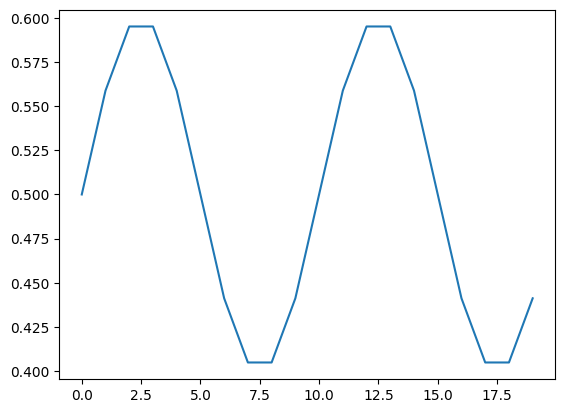

In [130]:
pv1 = zeros(iters) # the value measured by the photodiode
noise1 = lambda i: 0.1*sin(2*pi*i/10) # slow fiber drift

pv1[0] = 0.5

for i in range(1,iters):
    pv1[i] = pv1[0] + noise1(i)
plt.plot(pv1)